In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import optuna
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.animation as animation

Напишем функцию read_data, который будет приводить dataframe к удобному виду.

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def get_various_params_data(data: pd.DataFrame):
    return (data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 80)])

In [5]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X_transformed = np.array(np.abs(rfft(X[0, :])))
    for i in range(1, X.shape[0]):
        X_transformed = np.vstack((X_transformed, np.abs(rfft(X[i, :]))))
    data = pd.DataFrame(X_transformed, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [6]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [7]:
def get_all_features_and_targets(n_cols: int) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 1.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 1.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 1.0
    return pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)

In [8]:
vel_list = [8.33203125, 25.0, 40.0]
data = get_features_and_target(velocity=vel_list[2], load=True, n_cols=150)
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


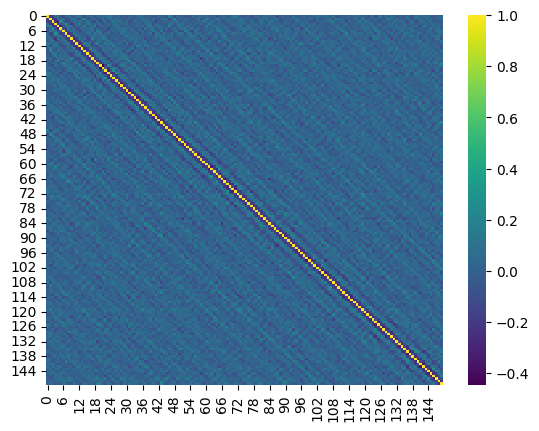

In [9]:
sns.heatmap(data.drop(columns='defect').corr(), cmap='viridis');

In [10]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [11]:
data = do_rfft_features(data)
data

,defect,0,1,2,3,4,5,6,7,8,...,66,67,68,69,70,71,72,73,74,75
0,eccentricity,525.300361,0.086251,0.064651,0.055709,0.043706,0.010399,0.103271,0.063116,0.107198,...,0.121369,0.017566,0.104780,0.062854,0.094239,0.057732,0.143755,0.179617,0.116678,0.155595
1,eccentricity,525.320228,0.096307,0.057703,0.065439,0.133730,0.086274,0.066657,0.029748,0.065393,...,0.134684,0.016750,0.073367,0.078766,0.061663,0.108380,0.117978,0.076330,0.068246,0.019819
2,eccentricity,525.290372,0.091189,0.041980,0.123393,0.072537,0.086720,0.108318,0.110195,0.095946,...,0.087457,0.052120,0.066383,0.148948,0.126035,0.218994,0.073965,0.042056,0.146307,0.034748
3,eccentricity,525.345796,0.051117,0.097616,0.082396,0.058996,0.025688,0.052397,0.013755,0.056942,...,0.075010,0.082815,0.018996,0.105550,0.112784,0.033298,0.119713,0.132907,0.015622,0.092434
4,eccentricity,525.055274,0.031709,0.104373,0.048793,0.069053,0.008650,0.103812,0.141121,0.052631,...,0.084934,0.100817,0.060511,0.079020,0.084821,0.163684,0.069359,0.114985,0.075826,0.097065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.300126,0.185319,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838
992,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.115612,0.256963,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946
993,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.057819,0.127003,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090
994,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.267125,0.161924,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863


In [12]:
data['defect'].value_counts()

defect
eccentricity           166
missing_tooth          166
no_fault               166
root_crack             166
surface_fault          166
tooth_chipped_fault    166
Name: count, dtype: int64

<Axes: >

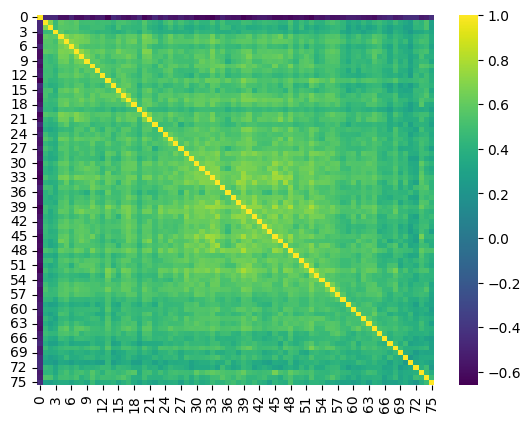

In [13]:
sns.heatmap(data.drop(columns='defect').corr(), cmap='viridis')

In [14]:
X = data.drop(columns='defect')
y = data['defect']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [18]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-03-30 16:40:10,668] A new study created in memory with name: no-name-2c630ac5-f68b-4ea5-aa10-a94a3b4f8c23
[I 2024-03-30 16:40:11,539] Trial 0 finished with value: 0.99375 and parameters: {'learning_rate': 0.07212699538416345, 'num_leaves': 2863, 'reg_lambda': 0.08086795563884697, 'min_child_samples': 48}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:40:12,098] Trial 1 finished with value: 0.96875 and parameters: {'learning_rate': 0.8214492417299792, 'num_leaves': 679, 'reg_lambda': 0.7833203738084046, 'min_child_samples': 77}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:40:12,479] Trial 2 finished with value: 0.8 and parameters: {'learning_rate': 1.6840254714133838, 'num_leaves': 905, 'reg_lambda': 0.8081424719865891, 'min_child_samples': 71}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:40:13,187] Trial 3 finished with value: 0.9625 and parameters: {'learning_rate': 1.6517907173055437, 'num_leaves': 1881, 'reg_lambda': 0.48145953538211894, 'min_chil

[I 2024-03-30 16:41:08,769] Trial 35 finished with value: 0.98125 and parameters: {'learning_rate': 0.16288144783029995, 'num_leaves': 1999, 'reg_lambda': 0.4803197837233383, 'min_child_samples': 37}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:41:10,444] Trial 36 finished with value: 0.96875 and parameters: {'learning_rate': 0.8815581304433866, 'num_leaves': 3108, 'reg_lambda': 0.5873230481609399, 'min_child_samples': 66}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:41:12,117] Trial 37 finished with value: 0.975 and parameters: {'learning_rate': 0.557384911605705, 'num_leaves': 2736, 'reg_lambda': 0.8106099428020657, 'min_child_samples': 71}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:41:14,209] Trial 38 finished with value: 0.99375 and parameters: {'learning_rate': 0.41299085969199134, 'num_leaves': 3895, 'reg_lambda': 0.6414501524978723, 'min_child_samples': 58}. Best is trial 0 with value: 0.99375.
[I 2024-03-30 16:41:15,016] Trial 39 finished with va

In [26]:
print(study.best_params)

{'learning_rate': 0.07212699538416345, 'num_leaves': 2863, 'reg_lambda': 0.08086795563884697, 'min_child_samples': 48}


In [27]:
best_params = {'learning_rate': 0.8814586632393469, 'num_leaves': 2290, 'reg_lambda': 0.9668567222949773, 'min_child_samples': 76}

In [28]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [29]:
accuracy

0.96

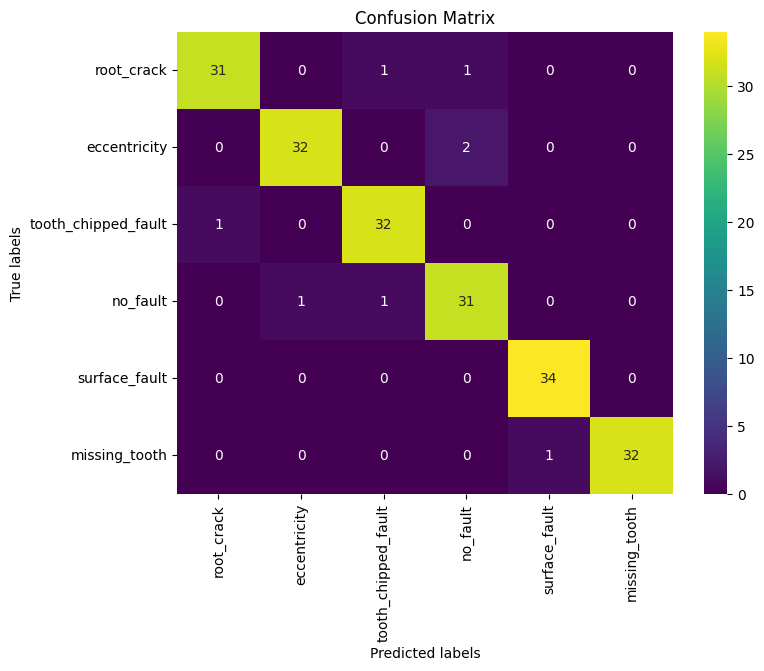

In [30]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
vel_list = [8.33203125, 25.0, 40.0]
data_eccentricity = read_data_and_choose('eccentricity.csv', velocity=vel_list[0], load=False)
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
data_eccentricity

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.522315,2.431974,3.503794,8.332031,0,eccentricity
1,0.0002,2.523629,2.431317,3.504284,8.332031,0,eccentricity
2,0.0004,2.522644,2.428032,3.501296,8.332031,0,eccentricity
3,0.0006,2.521987,2.430660,3.502646,8.332031,0,eccentricity
4,0.0008,2.522808,2.430168,3.502895,8.332031,0,eccentricity
...,...,...,...,...,...,...,...
24995,4.9990,2.522479,2.431153,3.503342,8.332031,0,eccentricity
24996,4.9992,2.520180,2.432631,3.502713,8.332031,0,eccentricity
24997,4.9994,2.522644,2.427704,3.501068,8.332031,0,eccentricity
24998,4.9996,2.524286,2.430496,3.504188,8.332031,0,eccentricity


In [32]:
data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity=vel_list[0], load=False)
missing_tooth_time = data_missing_tooth['time']
missing_tooth_disp = data_missing_tooth['displacements']
data_missing_tooth

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.520016,2.430496,3.501113,8.332031,0,missing tooth
1,0.0002,2.521822,2.430660,3.502527,8.332031,0,missing tooth
2,0.0004,2.519194,2.429511,3.499837,8.332031,0,missing tooth
3,0.0006,2.519851,2.428853,3.499854,8.332031,0,missing tooth
4,0.0008,2.518701,2.429346,3.499369,8.332031,0,missing tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.519851,2.430168,3.500766,8.332031,0,missing tooth
24996,4.9992,2.520673,2.429018,3.500560,8.332031,0,missing tooth
24997,4.9994,2.519358,2.428032,3.498930,8.332031,0,missing tooth
24998,4.9996,2.520508,2.428689,3.500213,8.332031,0,missing tooth


In [33]:
data_no_fault = read_data_and_choose('no_fault.csv', velocity=vel_list[0], load=False)
no_fault_time = data_no_fault['time']
no_fault_disp = data_no_fault['displacements']
data_no_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.523465,2.430168,3.503368,8.332031,0,No fault
1,0.0002,2.521494,2.430003,3.501835,8.332031,0,No fault
2,0.0004,2.522479,2.429675,3.502317,8.332031,0,No fault
3,0.0006,2.521330,2.431810,3.502971,8.332031,0,No fault
4,0.0008,2.522479,2.431317,3.503456,8.332031,0,No fault
...,...,...,...,...,...,...,...
24995,4.9990,2.520508,2.429839,3.501011,8.332031,0,No fault
24996,4.9992,2.520016,2.431153,3.501569,8.332031,0,No fault
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,No fault
24998,4.9996,2.521165,2.432960,3.503651,8.332031,0,No fault


In [34]:
data_root_crack = read_data_and_choose('root_crack.csv', velocity=vel_list[0], load=False)
root_crack_time = data_root_crack['time']
root_crack_disp = data_root_crack['displacements']
data_root_crack

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.519358,2.429675,3.500070,8.332031,0,Root crack
1,0.0002,2.519358,2.429839,3.500184,8.332031,0,Root crack
2,0.0004,2.521165,2.430496,3.501940,8.332031,0,Root crack
3,0.0006,2.520508,2.428853,3.500327,8.332031,0,Root crack
4,0.0008,2.519358,2.428689,3.499385,8.332031,0,Root crack
...,...,...,...,...,...,...,...
24995,4.9990,2.521494,2.429839,3.501721,8.332031,0,Root crack
24996,4.9992,2.520837,2.430496,3.501704,8.332031,0,Root crack
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,Root crack
24998,4.9996,2.520837,2.429182,3.500792,8.332031,0,Root crack


In [35]:
data_surface_fault = read_data_and_choose('surface_fault.csv', velocity=vel_list[0], load=False)
surface_fault_time = data_surface_fault['time']
surface_fault_disp = data_surface_fault['displacements']
data_surface_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.521001,2.427539,3.499771,8.332031,0,surface defect
1,0.0002,2.519851,2.428196,3.499398,8.332031,0,surface defect
2,0.0004,2.520016,2.426225,3.498149,8.332031,0,surface defect
3,0.0006,2.520016,2.428689,3.499859,8.332031,0,surface defect
4,0.0008,2.521165,2.427047,3.499547,8.332031,0,surface defect
...,...,...,...,...,...,...,...
24995,4.9990,2.515581,2.430989,3.498264,8.332031,0,surface defect
24996,4.9992,2.491928,2.441173,3.488413,8.332031,0,surface defect
24997,4.9994,2.545804,2.416206,3.509867,8.332031,0,surface defect
24998,4.9996,2.518537,2.439694,3.506442,8.332031,0,surface defect


In [36]:
data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity=vel_list[0], load=False)
tooth_chipped_fault_time = data_tooth_chipped_fault['time']
tooth_chipped_fault_disp = data_tooth_chipped_fault['displacements']
data_tooth_chipped_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.518209,2.430496,3.499812,8.332031,0,chipped tooth
1,0.0002,2.517880,2.429839,3.499120,8.332031,0,chipped tooth
2,0.0004,2.516402,2.427211,3.496231,8.332031,0,chipped tooth
3,0.0006,2.518537,2.427704,3.498110,8.332031,0,chipped tooth
4,0.0008,2.518701,2.427539,3.498114,8.332031,0,chipped tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.516895,2.428361,3.497384,8.332031,0,chipped tooth
24996,4.9992,2.519030,2.429018,3.499377,8.332031,0,chipped tooth
24997,4.9994,2.519030,2.426882,3.497895,8.332031,0,chipped tooth
24998,4.9996,2.518209,2.430003,3.499470,8.332031,0,chipped tooth


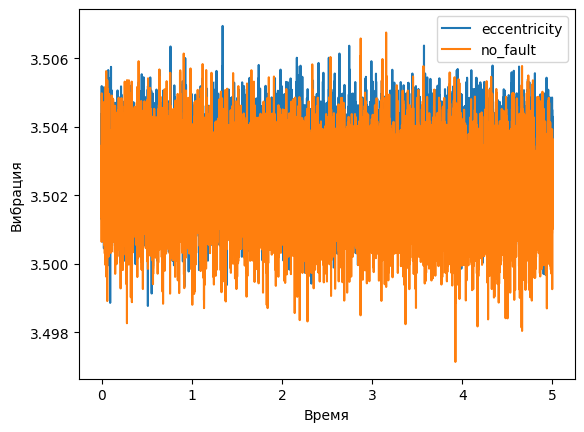

In [37]:
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

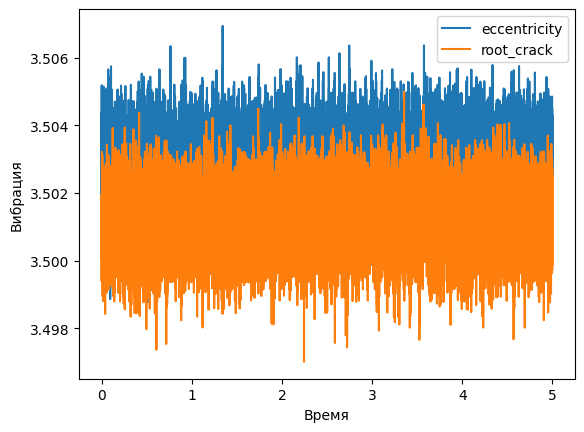

In [38]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(root_crack_time, root_crack_disp, label='root_crack')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

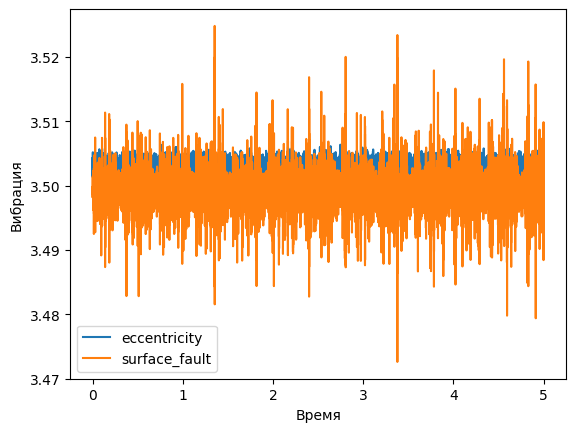

In [39]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(surface_fault_time, surface_fault_disp, label='surface_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

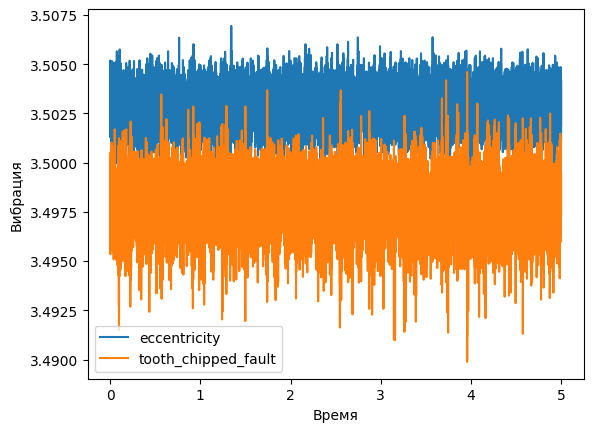

In [40]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(tooth_chipped_fault_time, tooth_chipped_fault_disp, label='tooth_chipped_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

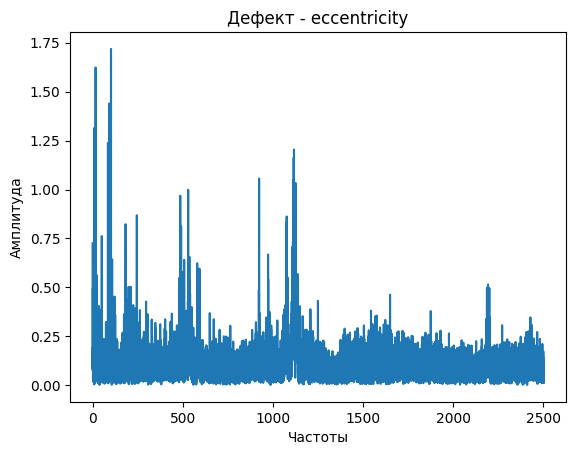

In [41]:
yf = rfft(eccentricity_disp.values)
xf = rfftfreq(n=eccentricity_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - eccentricity')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

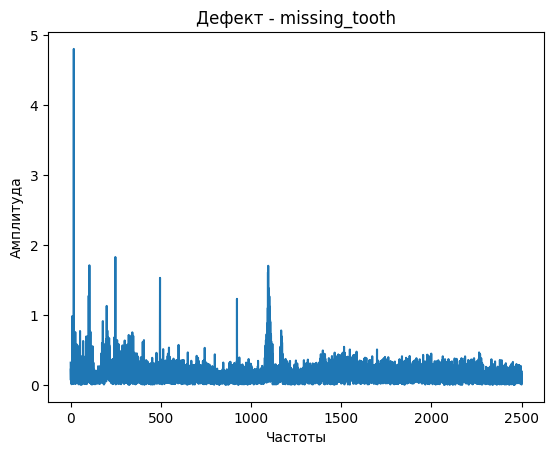

In [42]:
yf = rfft(missing_tooth_disp.values)
xf = rfftfreq(n=missing_tooth_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - missing_tooth')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

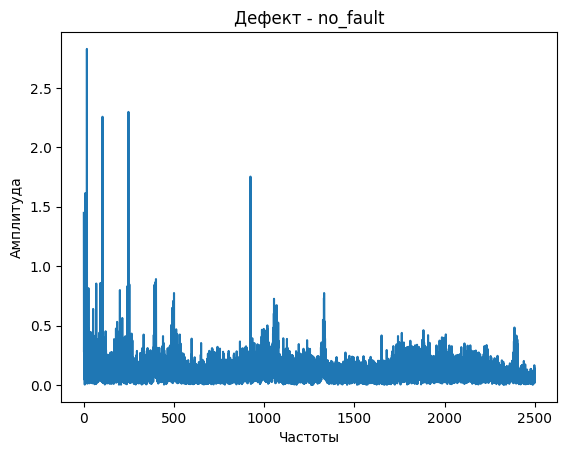

In [43]:
yf = rfft(no_fault_disp.values)
xf = rfftfreq(n=no_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - no_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

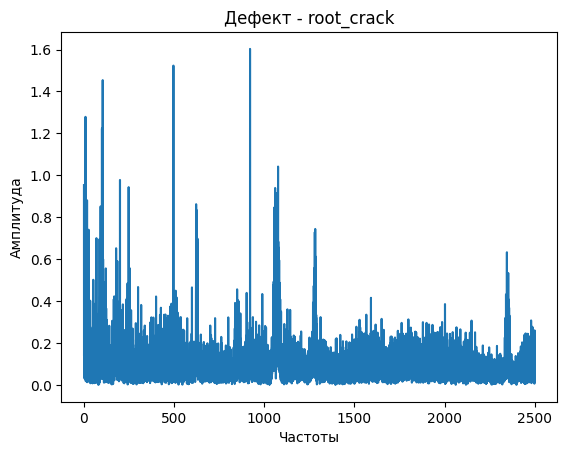

In [44]:
yf = rfft(root_crack_disp.values)
xf = rfftfreq(n=root_crack_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - root_crack')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

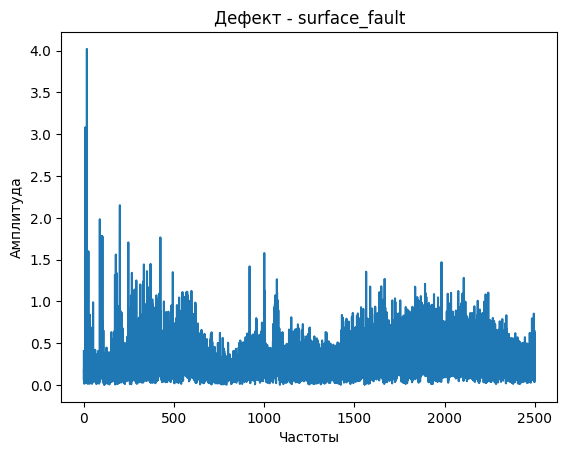

In [45]:
yf = rfft(surface_fault_disp.values)
xf = rfftfreq(n=surface_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - surface_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

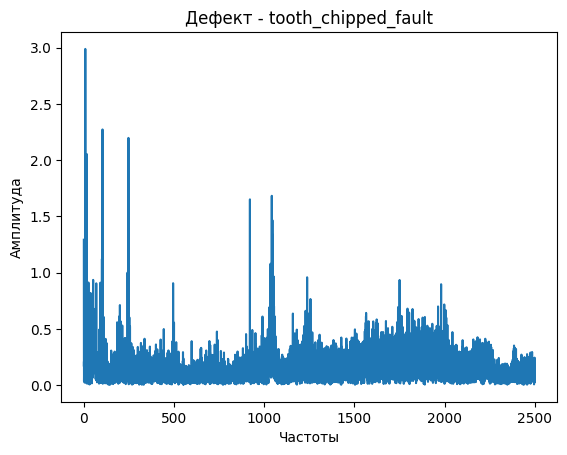

In [46]:
yf = rfft(tooth_chipped_fault_disp.values)
xf = rfftfreq(n=tooth_chipped_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - tooth_chipped_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

## Все данные

In [8]:
n_cols = 150
data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
data_1 = do_rfft_features(data_1)
data_1['velocity'] = 8.33203125
data_1['load'] = 0.0
data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
data_2 = do_rfft_features(data_2)
data_2['velocity'] = 8.33203125
data_2['load'] = 1.0
data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
data_3 = do_rfft_features(data_3)
data_3['velocity'] = 25.0
data_3['load'] = 0.0
data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
data_4 = do_rfft_features(data_4)
data_4['velocity'] = 25.0
data_4['load'] = 1.0
data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
data_5 = do_rfft_features(data_5)
data_5['velocity'] = 40.0
data_5['load'] = 0.0
data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
data_6 = do_rfft_features(data_6)
data_6['velocity'] = 40.0
data_6['load'] = 1.0
big_data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)

In [93]:
big_data = get_all_features_and_targets(n_cols=150)
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
992,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
993,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
994,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [49]:
X = big_data.drop(columns='defect')
y = big_data['defect']

In [108]:
cat_cols = ['velocity', 'load']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [110]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [111]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train, categorical_feature=cat_cols)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [112]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=100)

[I 2024-03-26 12:16:42,725] A new study created in memory with name: no-name-985646d3-bcdb-4a16-b2da-c61dd5b2bf01
[I 2024-03-26 12:16:43,664] Trial 0 finished with value: 0.9539748953974896 and parameters: {'learning_rate': 0.5714928728741862, 'num_leaves': 2899, 'reg_lambda': 0.9866539167328212, 'min_child_samples': 57}. Best is trial 0 with value: 0.9539748953974896.
[I 2024-03-26 12:16:44,656] Trial 1 finished with value: 0.9539748953974896 and parameters: {'learning_rate': 0.3082475863548788, 'num_leaves': 488, 'reg_lambda': 0.7865722250266597, 'min_child_samples': 29}. Best is trial 0 with value: 0.9539748953974896.
[I 2024-03-26 12:16:46,786] Trial 2 finished with value: 0.9267782426778243 and parameters: {'learning_rate': 0.6247180524611042, 'num_leaves': 2484, 'reg_lambda': 0.6763640989277674, 'min_child_samples': 1}. Best is trial 0 with value: 0.9539748953974896.
[I 2024-03-26 12:16:48,150] Trial 3 finished with value: 0.9581589958158996 and parameters: {'learning_rate': 0.22

[I 2024-03-26 12:17:24,459] Trial 32 finished with value: 0.9539748953974896 and parameters: {'learning_rate': 0.5376586438546703, 'num_leaves': 10, 'reg_lambda': 0.07371557317584561, 'min_child_samples': 83}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:17:25,729] Trial 33 finished with value: 0.9612970711297071 and parameters: {'learning_rate': 0.37643388368481834, 'num_leaves': 2126, 'reg_lambda': 0.17485288092646978, 'min_child_samples': 93}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:17:27,042] Trial 34 finished with value: 0.9623430962343096 and parameters: {'learning_rate': 0.3012918366366188, 'num_leaves': 2294, 'reg_lambda': 0.18537237474097637, 'min_child_samples': 94}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:17:28,291] Trial 35 finished with value: 0.952928870292887 and parameters: {'learning_rate': 0.3686307500851366, 'num_leaves': 2222, 'reg_lambda': 0.2073463043063326, 'min_child_samples': 97}. Best is 

[I 2024-03-26 12:18:06,947] Trial 64 finished with value: 0.9581589958158996 and parameters: {'learning_rate': 0.31713706646175244, 'num_leaves': 1583, 'reg_lambda': 0.3098495537476898, 'min_child_samples': 89}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:18:08,228] Trial 65 finished with value: 0.9550209205020921 and parameters: {'learning_rate': 0.5746983031282811, 'num_leaves': 2145, 'reg_lambda': 0.2575311806694451, 'min_child_samples': 86}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:18:09,550] Trial 66 finished with value: 0.9581589958158996 and parameters: {'learning_rate': 0.22231700631719198, 'num_leaves': 1393, 'reg_lambda': 0.04257851726157156, 'min_child_samples': 97}. Best is trial 27 with value: 0.9633891213389121.
[I 2024-03-26 12:18:10,882] Trial 67 finished with value: 0.9550209205020921 and parameters: {'learning_rate': 0.4598023874083466, 'num_leaves': 2327, 'reg_lambda': 0.10214749794258758, 'min_child_samples': 92}. Best 

In [113]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [114]:
accuracy

0.9506688963210702

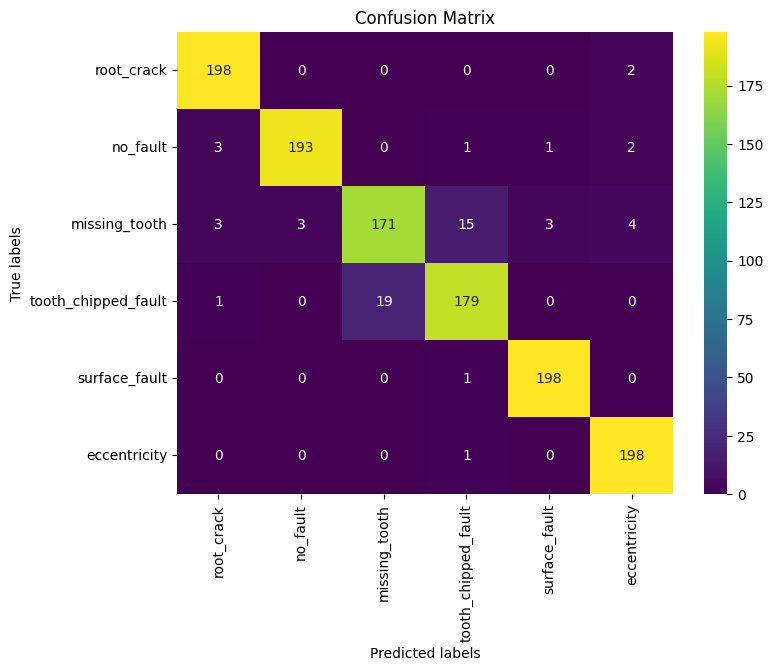

In [115]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Torch

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [95]:
class Custom_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, scale_num: bool, OHE: bool):
        if scale_num:
            num_cols = df.drop(columns=['defect', 'velocity', 'load']).columns
            scaler = StandardScaler()
            df[num_cols] = scaler.fit_transform(df[num_cols])
        if OHE:
            df = pd.get_dummies(df, columns=['velocity', 'load'], dtype=int)
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        feature = self.df.drop(columns='defect').values
        feature = np.array(feature, dtype=np.float32)
        label = self.df['defect'].values
        label = np.array(label, dtype=np.int32)
        return feature[idx, :], label[idx]

In [96]:
label_enc = LabelEncoder()
big_data['defect'] = label_enc.fit_transform(big_data['defect'])
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,0,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,0,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,0,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,0,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,0,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,5,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
992,5,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
993,5,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
994,5,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [97]:
df_train, df_test = train_test_split(big_data, train_size=0.7, stratify=big_data['defect'])

In [98]:
df_test

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
31,0,525.126222,0.130027,0.111009,0.078618,0.060919,0.060113,0.069800,0.120241,0.080415,...,0.021585,0.068341,0.073722,0.077779,0.108112,0.049058,0.076557,0.021160,40.000000,0.0
662,3,525.131215,0.010050,0.011895,0.034075,0.013334,0.021764,0.034557,0.006614,0.037025,...,0.012707,0.001892,0.011951,0.032200,0.009212,0.009849,0.002265,0.011142,8.332031,1.0
874,5,524.684898,0.027672,0.162474,0.059915,0.065238,0.042487,0.037302,0.078838,0.077896,...,0.089590,0.020035,0.020183,0.041575,0.117540,0.035958,0.049493,0.029043,40.000000,0.0
559,3,525.514984,0.020148,0.077011,0.095267,0.110212,0.025797,0.146106,0.038878,0.076095,...,0.233166,0.241272,0.062518,0.264010,0.018724,0.092699,0.092115,0.085297,40.000000,1.0
33,0,524.981376,0.051200,0.047028,0.016490,0.033556,0.035809,0.045806,0.047974,0.201460,...,0.026232,0.077298,0.080804,0.017124,0.040585,0.106025,0.073675,0.003914,25.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,3,525.153574,0.009638,0.000833,0.016381,0.011086,0.019580,0.014744,0.016438,0.028923,...,0.011024,0.017236,0.016614,0.007340,0.001283,0.009043,0.018248,0.002123,8.332031,1.0
697,4,523.600569,0.307294,0.640327,0.470084,0.393997,0.138099,0.240699,0.465756,0.173413,...,0.571017,0.576277,0.039794,0.801028,0.493199,0.204731,1.315887,0.572050,40.000000,1.0
901,5,524.719868,0.005716,0.035665,0.021873,0.014055,0.008514,0.036219,0.015554,0.085896,...,0.086189,0.018264,0.055177,0.043535,0.030038,0.029468,0.004271,0.040921,25.000000,0.0
918,5,524.979380,0.091401,0.040286,0.024860,0.024820,0.039170,0.060152,0.125496,0.234785,...,0.081821,0.014042,0.032746,0.053597,0.089637,0.014247,0.021905,0.038700,25.000000,1.0


In [99]:
df_train

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
435,2,524.509417,0.022175,0.027166,0.069296,0.023768,0.020472,0.086838,0.013480,0.203795,...,0.299839,0.153064,0.109600,0.080080,0.100157,0.088231,0.055086,0.120515,25.000000,1.0
246,1,524.540580,0.228301,0.303971,0.291854,0.132470,0.104362,0.128080,0.184156,0.107152,...,0.115246,0.055995,0.171643,0.200118,0.177960,0.261491,0.253492,0.055286,40.000000,1.0
841,5,524.913683,0.028030,0.026300,0.062019,0.019949,0.025691,0.040204,0.032094,0.249044,...,0.073613,0.034091,0.054649,0.030313,0.071984,0.061065,0.045756,0.030234,25.000000,1.0
784,4,524.432912,0.094249,0.041005,0.271248,0.119950,0.150255,0.139871,0.111666,0.559527,...,0.157472,0.057514,0.256178,0.180487,0.047522,0.227852,0.145848,0.220034,25.000000,1.0
740,4,524.916930,0.031732,0.041076,0.032415,0.011197,0.021620,0.017250,0.027115,0.023520,...,0.021687,0.024687,0.005406,0.004866,0.008116,0.017402,0.016179,0.020301,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1,525.208194,0.036723,0.007893,0.008203,0.011683,0.012999,0.009088,0.007940,0.085075,...,0.014077,0.007504,0.008111,0.015221,0.019601,0.012880,0.012931,0.004682,8.332031,1.0
939,5,525.144960,0.004889,0.008452,0.027972,0.012027,0.009226,0.008899,0.013865,0.061887,...,0.002659,0.008547,0.016292,0.013565,0.018469,0.006592,0.007574,0.008531,8.332031,1.0
443,2,525.337431,0.020384,0.009553,0.005916,0.022153,0.006503,0.023449,0.029494,0.022647,...,0.008656,0.013625,0.011944,0.028428,0.007017,0.006381,0.004308,0.000739,8.332031,1.0
810,4,524.831714,0.008731,0.007852,0.013562,0.021406,0.009374,0.037716,0.013937,0.082612,...,0.028920,0.062943,0.041547,0.010906,0.024270,0.034622,0.027634,0.021584,8.332031,1.0


In [100]:
train_dataset = Custom_Dataset(df_train, scale_num=True, OHE=True)
test_dataset = Custom_Dataset(df_test, scale_num=True, OHE=True)

In [101]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [102]:
class Net(nn.Module):
    def __init__(self):        
        super(Net, self).__init__() 
         
        self.fc1 = nn.Linear(81, 100)
        self.do1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(100, 6)
          
    def forward(self, x):                        
        x = self.fc1(x)                         
        x = nn.ReLU()(x)
        x = self.do1(x)
        x = self.fc2(x)
        return x
          
model = Net()               

In [103]:
criterion = torch.nn.CrossEntropyLoss()
optimezer = torch.optim.Adam(params=model.parameters(), lr=0.01)
#scheduler = lr_scheduler.ExponentialLR(optimezer, gamma=0.5)

In [104]:
epochs = 10
model.to(device)
train_loss_values = []
test_loss_values = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (X_train, label) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        label = label.to(device).long()
        optimezer.zero_grad()
        prediction = model(X_train)
        _, predictions = torch.max(prediction.data, 1)
        loss = criterion(prediction, label)
        loss.backward()
        optimezer.step()
        running_loss += loss.item()
        total += label.size(0)
        correct += (predictions == label).sum().item()
    print(f'Epoch №{epoch + 1}, Training loss = {running_loss / len(train_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on train = {correct / total * 100}%')
    train_loss_values.append(running_loss / len(train_dataloader))
    train_accuracy.append(correct / total * 100)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, label_val in test_dataloader:
            X_val = X_val.to(device)
            label_val = label_val.to(device).long()
            outputs = model(X_val)
            loss = criterion(outputs, label_val)
            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += label_val.size(0)
            correct += (predictions == label_val).sum().item()
    #scheduler.step()
    print(f'Epoch №{epoch + 1}, Test loss = {running_loss / len(test_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on test = {correct / total * 100}%')
    test_loss_values.append(running_loss / len(train_dataloader))
    test_accuracy.append(correct / total * 100)
    print('----------------------------------------------------------------')

Epoch №1, Training loss = 1.1602978814731946
Epoch №1, Accuracy on train = 53.31102079847%
Epoch №1, Test loss = 0.725163142295185
Epoch №1, Accuracy on test = 73.9542665923034%
----------------------------------------------------------------
Epoch №2, Training loss = 0.7503576341903571
Epoch №2, Accuracy on train = 70.4996414056897%
Epoch №2, Test loss = 0.5485545879807966
Epoch №2, Accuracy on test = 81.42777467930841%
----------------------------------------------------------------
Epoch №3, Training loss = 0.5415995121002197
Epoch №3, Accuracy on train = 78.98637341620847%
Epoch №3, Test loss = 0.4321905754763505
Epoch №3, Accuracy on test = 83.93753485778026%
----------------------------------------------------------------
Epoch №4, Training loss = 0.4479536861181259
Epoch №4, Accuracy on train = 82.57231651924457%
Epoch №4, Test loss = 0.4448737707631341
Epoch №4, Accuracy on test = 82.82208588957054%
----------------------------------------------------------------
Epoch №5, Trai

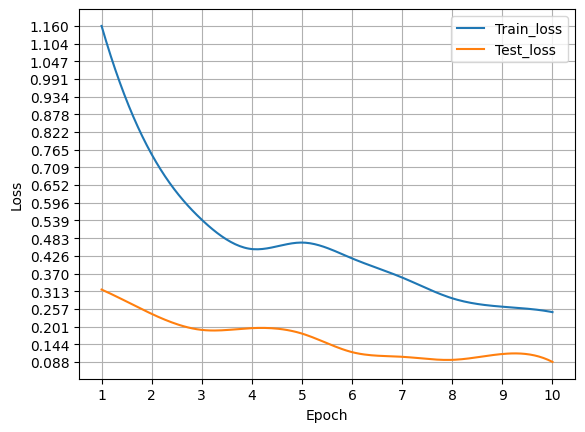

In [105]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_loss_values)
y2 = np.array(test_loss_values)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_loss')
plt.plot(xnew, y_smooth2, label='Test_loss')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(min(train_loss_values + test_loss_values), max(train_loss_values + test_loss_values), 20))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

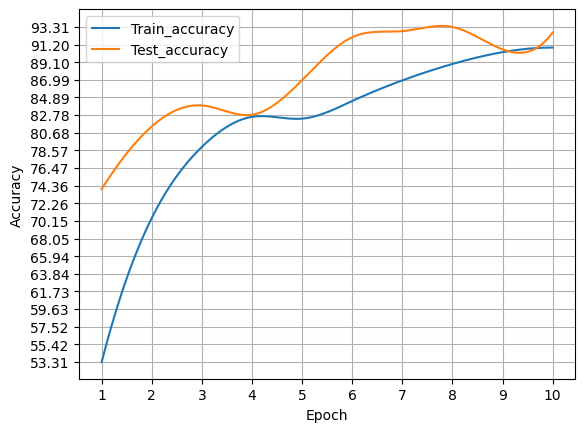

In [106]:
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_accuracy)
y2 = np.array(test_accuracy)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_accuracy')
plt.plot(xnew, y_smooth2, label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(min(train_accuracy + test_accuracy), max(train_accuracy + test_accuracy), 20))
plt.grid()
plt.legend()
plt.show()